In [1]:
import sys
sys.path.append("../../..")

### import libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import fisher_exact
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)
import utility
from pdf2image import convert_from_path
from PIL import Image
from IPython.display import display

##### Read gain data

In [3]:
df = pd.read_csv("yeast_evolved_genome_metadata.csv")

In [4]:
df.head()

,Position,CHROM,REF,ALT,population_name,G70_ref_counts,G1410_ref_counts,G2640_ref_counts,G5150_ref_counts,G7530_ref_counts,G10150_ref_counts,G70_alt_counts,G1410_alt_counts,G2640_alt_counts,G5150_alt_counts,G7530_alt_counts,G10150_alt_counts,accumulate_gain,kGain_evolved_genome
0,31,chrVIII,C,A,P3G06,35,31,59,38,42,56,0,0,0,0,11,0,-3.577119,-3.577119
1,34,2-micron,G,T,P1E04,74,104,3,0,0,1,0,217,426,323,156,236,0.392871,0.392871
2,34,chrII,G,A,P2C06,4,0,1,0,2,1,0,0,0,0,16,12,-4.563850,-4.311335
3,36,chrIX,C,A,P2F11,24,5,39,2,34,2,0,0,0,0,5,0,-11.012777,-11.012777
4,36,chrIX,C,A,P3F11,44,1,38,4,18,2,0,0,0,0,9,0,-11.012777,-11.012777


In [5]:
# df.head()

##### Read fitness data

In [6]:
df_finess = pd.read_excel("../../../data/yeast_metadata.xlsx", sheet_name="fitness")
df_finess

,population_name,Plate,Well,Gen70_s_R1,Gen70_s_R2,Gen70_s,Gen70_s_scaled,Gen550_s_R1,Gen550_s_R2,Gen550_s,...,Gen5150_s,Gen5150_s_scaled,Gen7530_s_R1,Gen7530_s_R2,Gen7530_s,Gen7530_s_scaled,Gen10150_s_R1,Gen10150_s_R2,Gen10150_s,Gen10150_s_scaled
0,P1A01,P1,A01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P1A02,P1,A02,-0.075306,-0.062071,-0.068689,-0.072925,-0.063589,-0.055622,-0.059606,...,0.016666,0.009374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P1A03,P1,A03,-0.077027,-0.076459,-0.076743,-0.080979,-0.046321,-0.042535,-0.044428,...,0.000769,-0.006523,0.008259,0.012947,0.010603,0.006367,0.014491,0.011513,0.013002,0.005710
3,P1A04,P1,A04,-0.071582,-0.080952,-0.076267,-0.080503,-0.052351,-0.056217,-0.054284,...,0.011147,0.003855,0.050515,0.048179,0.049347,0.045111,0.032640,0.032965,0.032803,0.025511
4,P1A05,P1,A05,-0.083521,-0.075293,-0.079407,-0.083643,-0.042366,-0.038459,-0.040412,...,0.011189,0.003897,0.027355,0.027544,0.027449,0.023213,0.032051,0.021394,0.026722,0.019430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,P3H08,P3,H08,0.012884,-0.063161,-0.025138,-0.005443,-0.029671,-0.009803,-0.019737,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
284,P3H09,P3,H09,0.000215,-0.061140,-0.030462,-0.010767,-0.052983,-0.030976,-0.041979,...,0.070635,0.114702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
285,P3H10,P3,H10,-0.027629,-0.096806,-0.062218,-0.042522,-0.066732,-0.037109,-0.051921,...,0.048310,0.092378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
286,P3H11,P3,H11,-0.082479,-0.179554,-0.131016,-0.111321,-0.068555,-0.072646,-0.070601,...,0.034874,0.078941,NaN,-0.359102,-0.359102,-0.339407,NaN,NaN,NaN,NaN


##### calculate sum of allele count across all generation

In [7]:
df["sum of alt AC"] = df['G70_alt_counts'] + df['G1410_alt_counts'] + \
df['G2640_alt_counts'] + df['G5150_alt_counts'] + df['G7530_alt_counts'] + df['G10150_alt_counts']
df.head()

,Position,CHROM,REF,ALT,population_name,G70_ref_counts,G1410_ref_counts,G2640_ref_counts,G5150_ref_counts,G7530_ref_counts,G10150_ref_counts,G70_alt_counts,G1410_alt_counts,G2640_alt_counts,G5150_alt_counts,G7530_alt_counts,G10150_alt_counts,accumulate_gain,kGain_evolved_genome,sum of alt AC
0,31,chrVIII,C,A,P3G06,35,31,59,38,42,56,0,0,0,0,11,0,-3.577119,-3.577119,11
1,34,2-micron,G,T,P1E04,74,104,3,0,0,1,0,217,426,323,156,236,0.392871,0.392871,1358
2,34,chrII,G,A,P2C06,4,0,1,0,2,1,0,0,0,0,16,12,-4.563850,-4.311335,28
3,36,chrIX,C,A,P2F11,24,5,39,2,34,2,0,0,0,0,5,0,-11.012777,-11.012777,5
4,36,chrIX,C,A,P3F11,44,1,38,4,18,2,0,0,0,0,9,0,-11.012777,-11.012777,9


##### Add allele switch column

In [8]:
df["allele switch"] = df["REF"]+ "->" + df["ALT"]
df.head()

,Position,CHROM,REF,ALT,population_name,G70_ref_counts,G1410_ref_counts,G2640_ref_counts,G5150_ref_counts,G7530_ref_counts,...,G70_alt_counts,G1410_alt_counts,G2640_alt_counts,G5150_alt_counts,G7530_alt_counts,G10150_alt_counts,accumulate_gain,kGain_evolved_genome,sum of alt AC,allele switch
0,31,chrVIII,C,A,P3G06,35,31,59,38,42,...,0,0,0,0,11,0,-3.577119,-3.577119,11,C->A
1,34,2-micron,G,T,P1E04,74,104,3,0,0,...,0,217,426,323,156,236,0.392871,0.392871,1358,G->T
2,34,chrII,G,A,P2C06,4,0,1,0,2,...,0,0,0,0,16,12,-4.563850,-4.311335,28,G->A
3,36,chrIX,C,A,P2F11,24,5,39,2,34,...,0,0,0,0,5,0,-11.012777,-11.012777,5,C->A
4,36,chrIX,C,A,P3F11,44,1,38,4,18,...,0,0,0,0,9,0,-11.012777,-11.012777,9,C->A


In [9]:
df = pd.merge(df, df_finess, on ="population_name", how= "left")

##### Convert the data to consider the mutation of all generation of every population format

In [10]:
import re

all_mutation = pd.DataFrame()
gen_list = ['G70_alt_counts', 'G1410_alt_counts', 'G2640_alt_counts', 'G5150_alt_counts', 'G7530_alt_counts',
            'G10150_alt_counts']

def extract_integer_from_string(s):

    import re

    # Sample string
    # my_string = "G10150_ref_counts"

    result = re.search(r'\d+', s)

    # Check if there is a match and extract the integer
    if result:
        extracted_integer = int(result.group())
        print(extracted_integer)
    else:
        print("No integer found in the string.")

    return extracted_integer



for i in gen_list:
    new_df_tmp = pd.DataFrame()
    new_df = df[df.loc[:, i]!=0]
    new_df_tmp = new_df[['CHROM', 'Position', 'allele switch', 'population_name']]
    new_df_tmp.loc[:, "generation"] = i
    new_df_tmp.loc[:, "kGain_wt"] = new_df.loc[:, "accumulate_gain"]
    new_df_tmp.loc[:, 'kGain_evolved_genome'] = new_df.loc[:, 'kGain_evolved_genome']
    new_df_tmp.loc[:, "allele count"] = new_df.loc[:, i]
    int_gen = extract_integer_from_string(i)
    
    col = "Gen"+ str(int_gen)+ "_s_scaled"
    new_df_tmp.loc[:, "fitness"] = new_df.loc[:, col]

    all_mutation = pd.concat([all_mutation, new_df_tmp], axis = 0)
    
all_mutation.reset_index(inplace=True, drop=True)
all_mutation['generation_number'] = all_mutation['generation'].str.extract(r'(\d+)').astype(int)

70
1410
2640
5150
7530
10150


In [11]:
all_mutation.head()

,CHROM,Position,allele switch,population_name,generation,kGain_wt,kGain_evolved_genome,allele count,fitness,generation_number
0,chrX,66,C->T,P1C11,G70_alt_counts,6.067923,6.067923,7,-0.024371,70
1,chrX,69,T->A,P1C11,G70_alt_counts,-4.705100,-4.705100,7,-0.024371,70
2,chrX,73,C->T,P1C11,G70_alt_counts,3.963808,3.963808,7,-0.024371,70
3,chrX,73,C->T,P2B04,G70_alt_counts,3.963808,3.963808,5,-0.095073,70
4,chrX,74,T->C,P1B02,G70_alt_counts,-2.479826,-2.479826,5,-0.065863,70


In [12]:
mutation_data_G10150 = all_mutation[all_mutation["generation"]=='G10150_alt_counts']
mutation_data_G10150.head()

,CHROM,Position,allele switch,population_name,generation,kGain_wt,kGain_evolved_genome,allele count,fitness,generation_number
414789,2-micron,34,G->T,P1E04,G10150_alt_counts,0.392871,0.392871,236,0.034785,10150
414790,chrII,34,G->A,P2C06,G10150_alt_counts,-4.563850,-4.311335,12,0.034504,10150
414791,chrII,38,T->A,P2C06,G10150_alt_counts,-9.926479,-9.926479,14,0.034504,10150
414792,chrII,51,T->G,P2C06,G10150_alt_counts,-8.706765,-8.706765,16,0.034504,10150
414793,chrII,52,G->T,P2C06,G10150_alt_counts,0.948235,0.969741,16,0.034504,10150


In [13]:
all_mutation.isna().any()

CHROM                   False
Position                False
allele switch           False
population_name         False
generation              False
kGain_wt                False
kGain_evolved_genome    False
allele count            False
fitness                 False
generation_number       False
dtype: bool

##### Fig. 6a

R[write to console]: Loading required package: ComplexHeatmap

R[write to console]: Loading required package: grid

R[write to console]: ========================================
ComplexHeatmap version 2.18.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


R[write to console]: Loading required package: circlize

R[write to console]: ========================================
circl

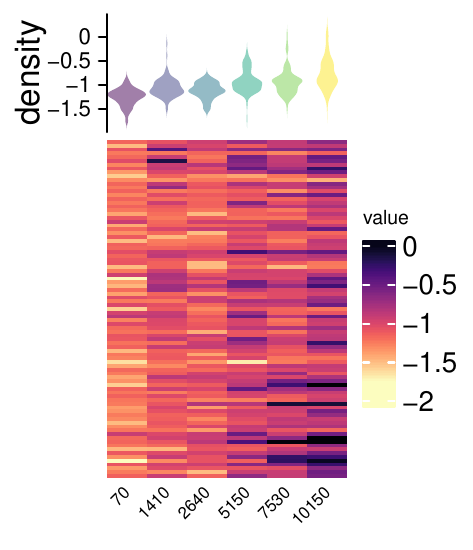

In [14]:
import pandas as pd
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pdf_file = "yeast_evolved_kGain_vs_population_with_generation_as_hue_heatmap.pdf"
pivot_table_median = all_mutation.pivot_table(index='population_name', columns='generation_number', aggfunc='median', values = "kGain_evolved_genome")


# Activate pandas-to-R conversion
pandas2ri.activate()

# Pass to R as matrix with row and column names
with (ro.default_converter + pandas2ri.converter).context():
    ro.globalenv['mat_py'] = ro.conversion.get_conversion().py2rpy(pivot_table_median)
    ro.globalenv['pdf_file'] = ro.conversion.get_conversion().py2rpy(pdf_file)

# R code to plot and save PDF (with your color palette, and 6x6 cm, 300 dpi)
r_code = '''
if (!require("ComplexHeatmap")) BiocManager::install("ComplexHeatmap", ask=FALSE)
if (!require("circlize")) install.packages("circlize")
if (!require("viridis")) install.packages("viridis")
library(ComplexHeatmap)
library(circlize)
library(viridis)

mat <- as.matrix(mat_py)



col_fun <- circlize::colorRamp2(
  seq(min(mat), max(mat), length.out = 100),
  rev(viridis::magma(100))
)


# Create the standard top annotation: one density plot per column
top_anno <- HeatmapAnnotation(
  density = anno_density(
    mat,                # No transpose, shape genes x generations
    type = "violin",    # Or "lines" for line density
    border = FALSE,
    gp = gpar(fill = viridis(ncol(mat), alpha = 0.5), col = NA),  # color by column
    height = unit(1.5, "cm")
  ),
  annotation_name_side = "left"
)

pdf(pdf_file, width=6/2.54, height=7/2.54)
ht <- Heatmap(
  mat,
  name = "value",
  col = col_fun,
  cluster_rows = FALSE,
  cluster_columns = FALSE,
  show_row_names = FALSE,
  show_column_names = TRUE,
  top_annotation = top_anno,
  column_names_rot = 45,
  heatmap_legend_param = list(
      legend_height = unit(1.5, "cm"),
      title_gp = gpar(fontsize = 7)
  ),
  column_names_gp = gpar(fontsize = 6)
)
draw(ht)
dev.off()




'''

# Run R code from Python
ro.r(r_code)

pages = convert_from_path(pdf_file, dpi=200)
display(pages[0])  # Show the first page as an image
